# Task 1 - Exploratory Data Analysis (EDA)
- This notebook aims to present the findings of my analysis, and also a detailed walkthrough of the steps taken to derive the results.

**Outline:**
1. [Data Loading](#data-loading)
2. [Basic Data Exploration](#basic-data-exploration)

    2a. [Findings](#findings)

    2ai. [Pre-purchase Survey](#pre-purchase-survey)

    2aii. [Post-trip Data](#post-cruise-data)
        
3. [Data Preprocessing](#data-preprocessing)

    3a. [Merging Dataset](#merging-both-datasets)

    3b. [Standardising Indicator Value](#standardising-indicator-values)

    3c. [Standardising Cruise Name](#standardising-cruise-name)

    3d. [Standising Cruise Distance](#standardising-cruise-distance)

    3e. [Correct Indicators with Invalid Ratings](#correct-indicators-with-invalid-ratings)

    3f. [Correct `Dining` column data type](#correct-data-type-of-dining-from-int64-to-float64)

    3g. [Encode `Ticket Type`, `Gender` and `Source of Traffic`](#encode-ticket-type-gender-and-source-of-traffic)

    3h. [Handling Missing Data](#handling-missing-values)

      3hi. [Drop NaN Rows in `Ticket Type` Column](#drop-nan-rows-in-ticket-type-column)

      3hii. [Imput NaN Rows in `Cruise Name` with Column Mode](#impute-nan-rows-in-cruise-name-with-column-mode)

      3hiii. [Impute NaN Rows in `Gender` with Column Mode](#impute-nan-rows-in-gender-with-column-mode)

      3hiv. [Impute NaN Rows in `Onboard Dining Service` to `Cleanliness` with Column Mode](#impute-nan-rows-in-onboard-dining-service-to-cleanliness-with-column-mode)

      3hvi. [Impute NaN Rows in `Cruise Distance` with Column Mean](#impute-nan-rows-with-mean-of-column-values-in-cruise-distance)
4. [Feature Engineering](#feature-engineering)

    4a. [Create `Age` Column from `Date of Birth` and `Logging`](#create-age-column-from-date-of-birth-and-logging)

    4b. [Create `Onboard Experience` Rating](#create-onboard-experience-rating)

    4c. [Create `Check-in Experience` Rating](#create-check-in-experience-rating)
    
5. [In-Depth Data Exploration](#in-depth-exploratory-data-analysis)

    5a. [Summary Statistics](#summary-statistics)

    5b. [General Distribution](#general-distribution)

    5bi. [Histogram of `Age` amd `Ticket Type`](#histogram-of-age-and-ticket-type)
        
    5bii. [Boxplot `Ticket Type` against `Age`](#boxplot-ticket-type-against-age)

    5biii. [Boxplot `Onboard Experience` against `Age`](#boxplot-onboard-experience-against-age)

    5c. [Random Forest Features Importance Analysis](#random-forest-features-importance-analysis)

    5d. [Correlation Analysis](#correlation-analysis)

# Data Loading
**Purpose:**
- Load and prepare database files into Python environment

## Preparing database ('.db') files

#### Use `sqlite3` library to prepare database ('.db') files

In [1]:
# Import required libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Define a 'get database connection' function for reusability and readability

In [2]:
# Define a function that returns database connection object

def get_db_connection(url):
    conn = sqlite3.connect(url)        # points database connection object to conn
    conn.row_factory = sqlite3.Row     # set return rows as dictionaries instead of tuples
    return conn

#### Load **cruise_pre.db** and **cruise_post.db** into Python environment
- Dataset are read into a list of dictionaries, with each dictionary representing an individual row of data

- This is an intermediary step before converting to DataFrame

In [3]:
# Read cruise_pre.db and cruise_post.db into list of dictionaries

# Define required variables to store data from db
cruise_pre_data = []
cruise_post_data = []

# Define variable to store name of the tables
table_name = ['cruise_pre','cruise_post']

# Iterate through the 2 provided data sets: cruise_pre.db and cruise_post.db
for table in table_name:

    # Create connection to database using defined function
    conn = get_db_connection('data/'+ table + '.db')
    # Execute query to fetch all rows and columns
    data = conn.execute('SELECT * FROM {}'.format(table)).fetchall()

    # Append row to respective variable store
    if table == 'cruise_pre':
        for row in data:
            cruise_pre_data.append(dict(row))
    else:
        for row in data:
            cruise_post_data.append(dict(row))

# close database connection after completion of task
conn.close()

# Output: cruise_pre_data and cruise_post_data now contains list of dictionaries

#### Convert list of dict to Pandas DataFrame
**Purpose:**
- Convert to Pandas DataFrame objects as it unlocks a wide variety of simple and clean data analytics libraries

In [4]:
# Read list of dictionaries into Pandas Dataframe
# Set 'index' column as index
cruise_post_df = pd.DataFrame(data=cruise_post_data).set_index('index')
cruise_pre_df = pd.DataFrame(data=cruise_pre_data).set_index('index')

# Basic Data Exploration
**Purpose:**
- Understanding of the structure, content and quality of the datasets
- Identify any missing data that may impact analysis

## Basic Information about the dataset using describe(), info() and sum()

In [5]:
cruise_pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133746 entries, 0 to 133745
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      120290 non-null  object 
 1   Date of Birth                               119062 non-null  object 
 2   Source of Traffic                           133746 non-null  object 
 3   Onboard Wifi Service                        114254 non-null  object 
 4   Embarkation/Disembarkation time convenient  118103 non-null  float64
 5   Ease of Online booking                      115391 non-null  float64
 6   Gate location                               116606 non-null  float64
 7   Logging                                     133746 non-null  object 
 8   Onboard Dining Service                      116937 non-null  object 
 9   Online Check-in                             118059 non-null  float64
 

In [6]:
cruise_pre_df.describe()

,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness
count,118103.000000,115391.000000,116606.000000,118059.000000,113494.000000,119914.000000,113453.000000,119399.000000,115419.000000,115344.000000
mean,3.055850,2.758170,2.978526,3.249884,3.439574,3.383925,3.633416,3.308470,3.641844,3.285745
std,1.526012,1.401888,1.277984,1.350811,1.321604,1.287508,1.178899,1.266476,1.177988,1.313328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
# Sum number of 0s for columns, looking out for the count for ratings
# as ratings cannot be 0

(cruise_pre_df == 0.0).sum()

Gender                                           0
Date of Birth                                    0
Source of Traffic                                0
Onboard Wifi Service                             0
Embarkation/Disembarkation time convenient    6036
Ease of Online booking                        5020
Gate location                                    1
Logging                                          0
Onboard Dining Service                           0
Online Check-in                               2770
Cabin Comfort                                    1
Onboard Entertainment                            0
Cabin service                                    5
Baggage handling                                 0
Port Check-in Service                            0
Onboard Service                                  5
Cleanliness                                     13
Ext_Intcode                                      0
dtype: int64

In [8]:
print(cruise_post_df.info())
print('\n')
print(cruise_post_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133746 entries, 0 to 133745
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Cruise Name      117815 non-null  object 
 1   Ticket Type      113685 non-null  object 
 2   Cruise Distance  119260 non-null  object 
 3   Ext_Intcode      133746 non-null  object 
 4   WiFi             64012 non-null   float64
 5   Dining           133746 non-null  int64  
 6   Entertainment    73689 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 8.2+ MB
None


               WiFi         Dining  Entertainment
count  64012.000000  133746.000000   73689.000000
mean       0.500578       0.499290       0.503142
std        0.500004       0.500001       0.499994
min        0.000000       0.000000       0.000000
25%        0.000000       0.000000       0.000000
50%        1.000000       0.000000       1.000000
75%        1.000000       1.000000       1.00000

## Understand the spread of missing values

In [9]:
# Print how many missing values in each data set

print('Pre-trip survey data')
print('Column Name --------------------------- Missing Values')
print(cruise_pre_df.isnull().sum())
print('\nPost-cruise data')
print('Column Name -- Missing Values')
print(cruise_post_df.isnull().sum())

Pre-trip survey data
Column Name --------------------------- Missing Values
Gender                                        13456
Date of Birth                                 14684
Source of Traffic                                 0
Onboard Wifi Service                          19492
Embarkation/Disembarkation time convenient    15643
Ease of Online booking                        18355
Gate location                                 17140
Logging                                           0
Onboard Dining Service                        16809
Online Check-in                               15687
Cabin Comfort                                 20252
Onboard Entertainment                         15913
Cabin service                                 13832
Baggage handling                              20293
Port Check-in Service                         14347
Onboard Service                               18327
Cleanliness                                   18402
Ext_Intcode                             

Text(0.5, 1.0, 'cruise_post_df')

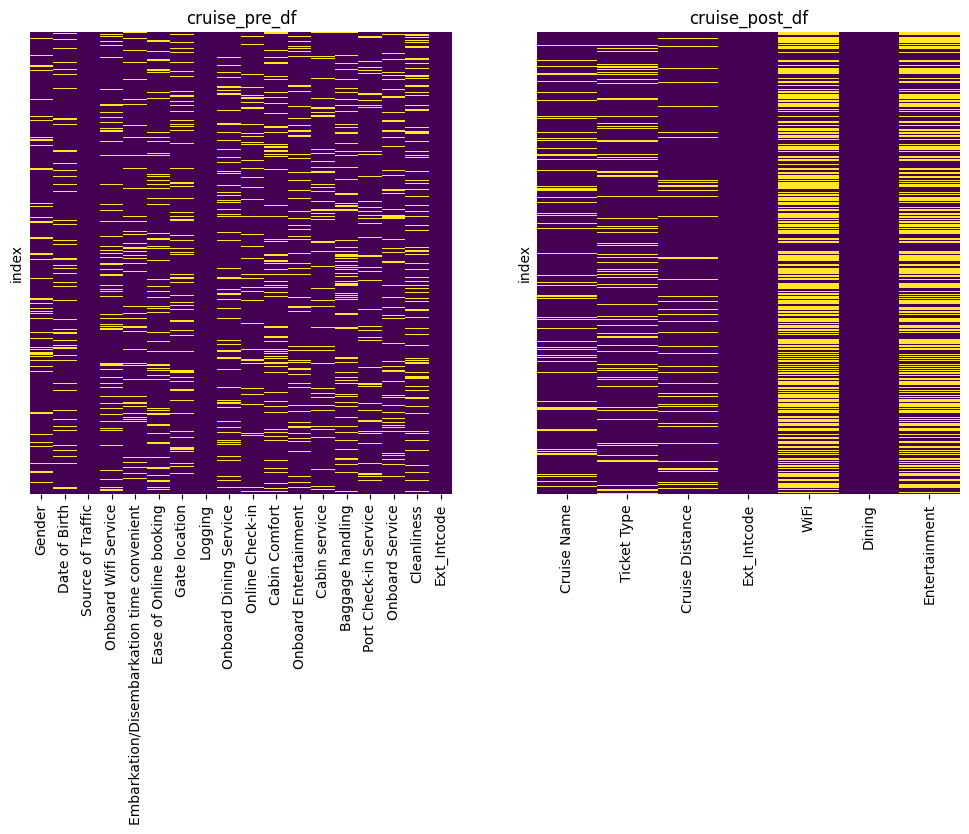

In [10]:
# Visualise the null values in each data set

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap (cruise_pre_df)
sns.heatmap(cruise_pre_df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('cruise_pre_df')

# Plot the second heatmap (cruise_post_df)
sns.heatmap(cruise_post_df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes[1])
axes[1].set_title('cruise_post_df')


## Understand the values in the columns

Executing the next line, we can see the different values in `Onboard Wifi Service`, `Onboard Entertainment` and `Onboard Dining Service` columns:
1. 'A little important'
2. 'Extremely important'
3. 'Not at all important'
4. 'Somewhat important'
5. 'Very important'

And these are the values for `Ticket Tier`
1. 'Deluxe'
2. 'Luxury'
3. 'Standard'

In [11]:
# Summarise the values for some columns in pre-trip data
scale_summary = pd.concat([cruise_pre_df.groupby('Onboard Wifi Service').size(),
                        cruise_pre_df.groupby('Onboard Entertainment').size(),
                        cruise_pre_df.groupby('Onboard Dining Service').size()],
                        axis=1,
                        keys=['Wifi Service Count', 'Entertainment Count', 'Dining Service Count'])
scale_summary

,Wifi Service Count,Entertainment Count,Dining Service Count
A little important,29383,20009,24763
Extremely important,13031,28625,25149
Not at all important,20236,14205,14468
Somewhat important,29101,21627,25037
Very important,22503,33367,27520


In [12]:
# Summarise values in Ticket Type in post-trip data
cruise_post_df.groupby('Ticket Type').size()

Ticket Type
Deluxe       8260
Luxury      54414
Standard    51011
dtype: int64

## Findings
These findings are made based on the investigations in the previous segments.

### Pre-purchase survey
Description
- This is a pre-purchase survey conducted to give ShipSail insights into what ameneties/services their customers prefer, or what is considered important to them for an enjoyable cruise journey.

**Missing values, or NaN fields**
- Spread of missing data is very even across all feature columns
- Missing data from each column is generally small, roughly 20% to 30% (visually)
- Imputation will be used to replace missing values

**Inconsistent label format**
- For example, `Onboard Wifi Service` has a categorical label while `Ease of Online booking` has a numerical label, both being a preferance rating
- Inconsistent format makes data plotting across these variables difficult
- Based on the unique values, the categorically labelled fields are in order, can be easily mapped to their corresponding numerical value, as per the scale given in AIAP15 instructions
- Encode all categorical labels into corresponding numerical label of 1.0 to 5.0

**Incorrect ratings**
- Some ratings are 0, which is invalid




In [13]:
# Display part of cruise pre dataset
cruise_pre_df.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


### Post-cruise Data
Description:
- This is the post trip data, which contains the target variable 'Ticket Type' we are trying to predict.

**Missing values, or NaN fields in Ticket Type**
- About 15% missing values
- Imputation is not recommended for the target variable, as it can introduce bias, incorrect or misleading information.
- These rows will be dropped for this project.

**Unique values in Ticket Type**
- Deluxe (8260), Luxury (54414), Standard (51011)

In [14]:
# Display part of cruise post dataset
cruise_post_df.head()

,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode,WiFi,Dining,Entertainment
index,,,,,,,
0,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0
4,Lapras,Standard,1145 Miles,LB218CFLOBS,NaN,1,NaN


# Data Preprocessing
**Purpose:**
- Process the raw data to make it suitable for further analysis or modelling, by handling missing values, encoding categorical variables, and perform other necessary transformations

## Merging both datasets
**Purpose:** 
- combining pre-cruise survey data and post-cruise data creates a more comprehensive and unifed dataset, allowing analysis of the relationship between both sets
- it also creates a direct link between the pre-cruise survey responses (features) and the ticket tier column (target variable) from post-cruise data

In [15]:
# Create a new variable that holds the merged set of Dataset 1 and 2

merged_data = cruise_pre_df.merge(cruise_post_df, left_on='Ext_Intcode', right_on='Ext_Intcode')

# Display part of the new merged dataset
merged_data.head(3)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,...,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,...,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,...,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0


## Standardising Indicator Values

**Purpose:**
1. inconsistent format makes data plotting across these variables difficult
2. machine learning algorithms require numeric input variables

3 Scale Columns are categorically labelled: 
1. `Onboard Wifi Service`
2. `Onboard Entertainment`
3. `Onboard Dining Service`

**Conclusion:**
- All feature columns will be consistent


In [16]:
# Based on the findings, there are no misspelling or outliers to be handled

# Define a string-to-value map to help encode these columns
scale_map = {'Not at all important':1.0,
                'A little important':2.0,
                'Somewhat important':3.0,
                'Very important': 4.0,
                'Extremely important':5.0}

# Store columns to encode
encode_columns = ['Onboard Wifi Service', 'Onboard Entertainment', 'Onboard Dining Service']

# Iterate encoding for each column
for column in encode_columns:
    merged_data[column] = merged_data[column].map(scale_map)

In [17]:
# Show part of the resulting dataframe
merged_data.head(3)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,2.0,3.0,5.0,3.0,01/01/2023 0:00,4.0,2.0,...,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,1.0,4.0,1.0,NaN,01/01/2023 0:01,4.0,NaN,...,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,NaN,3.0,0.0,5.0,01/01/2023 0:02,NaN,NaN,...,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0


## Standardising `Cruise Name`

Running the line of code below, these are the values found:
1. "Blastoise"
2. "IAPRAS"
3. "Lapras"
4. "blast"
5. "blast0ise"
6. "blastoise"
7. "blastoise"
8. "lap"
9. "lapras"

There are only 2 cruises, and the correct spellings are:
1. "Blastoise"
2. "Lapras"

In [18]:
# Find unique values in Cruise Name
merged_data.groupby('Cruise Name').size()

Cruise Name
Blastoise    73209
IAPRAS        3043
Lapras       32823
blast         3226
blast0ise     3070
blastoise     3073
lap           3068
lapras        3125
dtype: int64

In [19]:
# Define function to replace misspellings with correct spelling
def correct_spelling(cruise_name):
    # Define a list to store misspellings
    blastoise_misspell = ['blast', 'blast0ise', 'blastoise']
    lapras_misspell = ['IAPRAS', 'lap', 'lapras']

    if cruise_name in blastoise_misspell:
        return 'Blastoise'
    elif cruise_name in lapras_misspell:
        return 'Lapras'
    else:
        return cruise_name  # Return the original name if not a misspelling

# Apply function to 'Cruise Name' column
merged_data['Cruise Name'] = merged_data['Cruise Name'].apply(correct_spelling)

## Standardising `Cruise Distance`
**Purpose:**
- To fix incorrect values under cruise distance column
- Some distance are in different units and/or negative

**Proposal:**
- Standardise unit to KM
- Apply absolute function to negative distances

In [20]:
merged_data.groupby('Cruise Distance').size()

Cruise Distance
-100 KM         2
-1004 KM        1
-1005 KM       10
-1005 Miles     2
-1008 KM        4
               ..
997 Miles      10
998 KM         43
998 Miles       4
999 KM         32
999 Miles       2
Length: 8995, dtype: int64

In [21]:
import re

def convert_to_km(distance):
    numbers = re.findall(r'\d+', distance)
    if numbers:
        if 'Miles' in distance:
            return int(numbers[0]) * 1.60934  # Convert miles to kilometers
        else:
            return int(numbers[0])

# Apply the conversion function to each element in the Series
# merged_data['Cruise Distance'] = merged_data['Cruise Distance'].apply(lambda x: convert_to_km(x) if '-' not in x else abs(convert_to_km(x)))
merged_data['Cruise Distance'] = merged_data['Cruise Distance'].apply(lambda x: convert_to_km(x) if x else None)

# Convert the Series back to numeric type
merged_data['Cruise Distance'] = pd.to_numeric(merged_data['Cruise Distance'])

# Now, cruise_distance_series contains standardized distances in KM


## Correct Indicators with Invalid Ratings
**Purpose:**
- Ratings cannot 0, we need to either remove or do imputation

**Thought Process:**
- From [Basic Data Exploration](#basic-data-exploration), these ratings have invalid ratings (0 for rating)

| Rating        | Zero Count      |
| ---------------------| ------------------- |
|Embarkation/Disembarkation time convenient|6036
|Ease of Online booking|5020
|Gate location|  1
|Online Check-in|2770
|Cabin Comfort|  1
|Cabin service| 5
|Onboard Service|5
|Cleanliness|13

- Propose to assign `1.0` to these ratings, assuming that customers attempted to give the lowest rating

In [22]:
# Assigning 1.0 to these columns

# Define a list of rating columns
rating_columns = ['Onboard Wifi Service',
                 'Embarkation/Disembarkation time convenient',
                 'Ease of Online booking',
                 'Gate location',
                 'Onboard Dining Service',
                 'Online Check-in',
                 'Cabin Comfort',
                 'Onboard Entertainment',
                 'Cabin service',
                 'Baggage handling',
                 'Port Check-in Service',
                 'Onboard Service',
                 'Cleanliness']

# Define function to check and replace incorrect ratings
def correct_ratings(rating):
    return rating.apply(lambda x: 1.0 if x == 0.0 or x == 0 else x)

# Apply function to rating columns
merged_data[rating_columns] = merged_data[rating_columns].apply(correct_ratings)

## Correct data type of `Dining` from int64 to float64


In [23]:
# Convert 'Dining' data type to float
merged_data['Dining'] = merged_data['Dining'].astype(float)

## Encode `Ticket Type`, `Gender` and `Source of Traffic`
**Purpose:**
- Models and algorithms require data to be in numerics
- In case of categorical labels, we can encode them ordinally

**Ticket Type**
- Standard = 0
- Deluxe = 1
- Luxury = 2

**Gender**
- Male = 0
- Female = 1

**Source of Traffic**
- Direct - Company Website = 0
- Direct - Email Marketing = 1
- Indirect - Search Engine = 2
- Indirect - Social Media = 3

In [24]:
# Encode Ticket Type
ticket_type_mapping = {'Standard': 0, 'Deluxe': 1, 'Luxury': 2}
merged_data['Ticket Type'] = merged_data['Ticket Type'].replace(ticket_type_mapping)

# Encode Gender
gender_mapping = {'Male': 0, 'Female': 1}
merged_data['Gender'] = merged_data['Gender'].replace(gender_mapping)

# Encode Source of Traffic
source_of_traffic_mapping = {
    'Direct - Company Website': 0,
    'Direct - Email Marketing': 1,
    'Indirect - Search Engine': 2,
    'Indirect - Social Media': 3
}
merged_data['Source of Traffic'] = merged_data['Source of Traffic'].replace(source_of_traffic_mapping)


## Handling Missing Values

### Drop NaN rows in `Ticket Type` column
- This is our target variable, imputing NaN rows may lead to bias or inaccuracy in the model.

In [25]:
# Drop missing data
merged_data.dropna(subset=['Ticket Type'], inplace=True)


### Impute NaN Rows in `Cruise Name` with Column Mode

In [26]:
# Replace missing data with the column's mode
merged_data['Cruise Name'].fillna(merged_data['Cruise Name'].mode()[0], inplace=True)

### Impute NaN Rows in `Gender` with Column Mode

In [27]:
# Replace missing data with the column's mode
merged_data['Gender'].fillna(merged_data['Gender'].mode()[0], inplace=True)

In [28]:
merged_data.groupby('Gender').size()

Gender
0.0    53433
1.0    66849
dtype: int64

In [29]:
merged_data.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
1,1.0,None,3,1.0,4.0,1.0,NaN,01/01/2023 0:01,4.0,NaN,...,4.0,4.0,4.0,LB138HKBECM,Blastoise,1.0,672.0000,NaN,0.0,1.0
2,1.0,22/07/1998,2,NaN,3.0,1.0,5.0,01/01/2023 0:02,NaN,NaN,...,2.0,3.0,NaN,BL713UHBAAN,Lapras,1.0,1167.0000,NaN,0.0,0.0
3,1.0,01/05/1970,0,4.0,4.0,4.0,4.0,01/01/2023 0:05,3.0,4.0,...,3.0,2.0,4.0,LB243DMKCFL,Lapras,1.0,280.0000,NaN,0.0,1.0
4,0.0,07/01/1960,0,3.0,4.0,2.0,NaN,01/01/2023 0:06,1.0,2.0,...,5.0,2.0,NaN,LB218CFLOBS,Lapras,0.0,1842.6943,NaN,1.0,NaN
5,0.0,07/01/1960,0,3.0,4.0,2.0,NaN,01/01/2023 0:06,1.0,2.0,...,5.0,2.0,NaN,LB218CFLOBS,Lapras,0.0,1842.6943,NaN,1.0,NaN


### Impute NaN rows in `Onboard Dining Service` to `Cleanliness` with Column Mode

In [30]:
# Define columns to be replaced
rating_columns = ['Onboard Wifi Service',
                 'Embarkation/Disembarkation time convenient',
                 'Ease of Online booking',
                 'Gate location',
                 'Onboard Dining Service',
                 'Online Check-in',
                 'Cabin Comfort',
                 'Onboard Entertainment',
                 'Cabin service',
                 'Baggage handling',
                 'Port Check-in Service',
                 'Onboard Service',
                 'Cleanliness']

# Replace missing data with the column's mode
for column in rating_columns:
    merged_data[column].fillna(merged_data[column].mode()[0], inplace=True)

### Impute NaN rows with mean of column values in `Cruise Distance` 

In [31]:
merged_data['Cruise Distance'].fillna(merged_data['Cruise Distance'].mean(), inplace=True)

<Axes: >

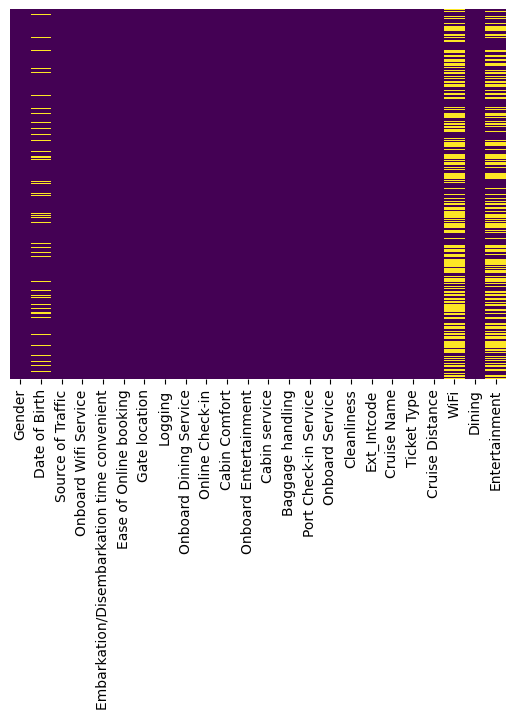

In [32]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## **Resulting data so far:**
- All scales are in proper numerical label, and missing values are filled via `mode` imputation
- Gender was assigned binary label (`Male` = 0, `Female` = 1), and missing values are filled via `mode` imputation
- Source of Traffic was ordinally labelled and missing values filled via `mode` imputation
    - `'Direct - Company Website':0.0`
    - `'Direct - Email Marketing':1.0`
    - `'Indirect - Search Engine':2.0`
    - `'Indirect - Social Media':3.0`

In [33]:
# Show part of resulting cruise_pre_df
merged_data.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
1,1.0,None,3,1.0,4.0,1.0,3.0,01/01/2023 0:01,4.0,4.0,...,4.0,4.0,4.0,LB138HKBECM,Blastoise,1.0,672.0000,NaN,0.0,1.0
2,1.0,22/07/1998,2,2.0,3.0,1.0,5.0,01/01/2023 0:02,4.0,4.0,...,2.0,3.0,4.0,BL713UHBAAN,Lapras,1.0,1167.0000,NaN,0.0,0.0
3,1.0,01/05/1970,0,4.0,4.0,4.0,4.0,01/01/2023 0:05,3.0,4.0,...,3.0,2.0,4.0,LB243DMKCFL,Lapras,1.0,280.0000,NaN,0.0,1.0
4,0.0,07/01/1960,0,3.0,4.0,2.0,3.0,01/01/2023 0:06,1.0,2.0,...,5.0,2.0,4.0,LB218CFLOBS,Lapras,0.0,1842.6943,NaN,1.0,NaN
5,0.0,07/01/1960,0,3.0,4.0,2.0,3.0,01/01/2023 0:06,1.0,2.0,...,5.0,2.0,4.0,LB218CFLOBS,Lapras,0.0,1842.6943,NaN,1.0,NaN


# Feature Engineering

## Create `Age` column from `Date of Birth` and `Logging`
**Purpose:** 
- Create a more usable variable that can give more insights into the demographics

In [34]:
def convert_to_dmy(date_of_birth):
    if date_of_birth is not None:
        try:
            # Try to parse the date assuming %d/%m/%Y format
            date_obj = pd.to_datetime(date_of_birth, format='%d/%m/%Y')
            return date_obj.strftime('%d/%m/%Y')
        except ValueError:
            try:
                # If parsing fails, try parsing with %Y/%d/%m format
                date_obj = pd.to_datetime(date_of_birth, format='%Y/%d/%m')
                return date_obj.strftime('%d/%m/%Y')
            except ValueError:
                try:
                    # If parsing fails, try parsing with %Y/%m/%d format
                    date_obj = pd.to_datetime(date_of_birth, format='%Y/%m/%d')
                    return date_obj.strftime('%d/%m/%Y')
                except ValueError:
                    # If all formats fail, return the original value
                    return date_of_birth
    else:
        return date_of_birth


# Apply function to every row in cruise_pre_df
merged_data['Date of Birth'] = merged_data['Date of Birth'].apply(convert_to_dmy)

# Add a new column 'Age', compute age by subtracting logging date by their date of birth, getting the quotient after dividing by 365
merged_data['Age'] = (pd.to_datetime(merged_data['Logging'], format='%d/%m/%Y %H:%M') - pd.to_datetime(merged_data['Date of Birth'], format='%d/%m/%Y')).dt.days // 365


Running the next line, there guests who are aged over 120, which is most likely an error.

Solution:
- Drop rows with age > 120

In [35]:
# Summarise counts of age more than 80
merged_data[merged_data['Age']>80].groupby('Age').size()

Age
84.0     15
85.0      9
123.0    27
124.0    40
125.0    40
         ..
219.0    54
220.0    46
221.0    41
222.0    37
223.0    15
Length: 103, dtype: int64

In [36]:
# Keep rows with age <= 120
merged_data = merged_data[merged_data['Age'] <= 120]

## Create `Onboard Experience` rating
- This feature will take the average of the services that guests will experience while on the cruise

Indicators considered:
- Onboard Wifi Service
- Onboard Dining Service
- Cabin Comfort
- Onboard Entertainment
- Cabin Service
- Cleanliness

In [37]:
# Define the list of columns to be averaged
onboard_experience_columns = ['Onboard Wifi Service', 'Onboard Dining Service',
                              'Cabin Comfort', 'Onboard Entertainment',
                              'Cabin service', 'Cleanliness']

# Calculate the average for the new column
merged_data['Onboard Experience'] = merged_data[onboard_experience_columns].mean(axis=1).round()


## Create `Check-in Experience` rating
- This feature will take the average of the services that guest experiences while checking in before their trip

Indicators considered:
- Embarkation/Disembarkation time convenient
- Gate location
- Online Check-in
- Baggage handling
- Port Check-in Service

In [38]:
# Define the list of columns to be averaged
check_in_experience_columns = ['Embarkation/Disembarkation time convenient', 
                                'Gate location', 
                                'Online Check-in', 
                                'Baggage handling', 
                                'Port Check-in Service']

# Calculate the average for the new column
merged_data['Check-in Experience'] = merged_data[check_in_experience_columns].mean(axis=1).round()

# In-Depth Exploratory Data Analysis
**Purpose:** 
- Gain deeper insights into the dataset

## Summary Statistics
**Description:** 
- Gain deeper insights into the dataset

**Interpretation of findings:**

Pre-cruise survey
- On average, all the service indicators are above average, indicating relevance
- `Onboard Wifi Service` is the least desired, with mean rating of 2.7
- `Baggage handling` is the most desired, with mean rating of 3.70 
- Average `Age` is 38.8, with relatively high standard deviation of 15.1 indicates a wide spread of ages, with most passengers being middle-aged

Post-cruise data
- `Wifi` and `Dining` less than 0.5 indicates that more passengers find these services non-satisfactory

In [39]:
# Summary statistics of dataset
merged_data.describe()

,Gender,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,...,Onboard Service,Cleanliness,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment,Age,Onboard Experience,Check-in Experience
count,102806.000000,102806.000000,102806.000000,102806.000000,102806.000000,102806.000000,102806.000000,102806.000000,102806.000000,102806.000000,...,102806.000000,102806.000000,102806.000000,102806.000000,49056.000000,102806.000000,56554.000000,102806.000000,102806.000000,102806.000000
mean,0.556261,0.873412,2.692314,3.212264,2.831022,2.981217,3.303368,3.355845,3.535027,3.433798,...,3.692246,3.399160,1.027275,1263.807829,0.498410,0.499290,0.504456,38.763175,3.312141,3.326868
std,0.496827,0.922726,1.196363,1.378816,1.232405,1.190566,1.269097,1.244667,1.219882,1.269145,...,1.100459,1.233066,0.962461,1035.689599,0.500003,0.500002,0.499985,15.134818,0.847276,0.712161
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000
25%,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,...,3.000000,3.000000,0.000000,479.000000,0.000000,0.000000,0.000000,26.000000,3.000000,3.000000
50%,1.000000,1.000000,2.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,1.000000,1005.000000,0.000000,0.000000,1.000000,39.000000,3.000000,3.000000
75%,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,2.000000,1660.000000,1.000000,1.000000,1.000000,50.000000,4.000000,4.000000
max,1.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,2.000000,7987.154420,1.000000,1.000000,1.000000,85.000000,5.000000,5.000000


## General Distribution

### Plot histogram of `Age` and `Ticket Type`
**Findings:**
- Majority of guests purchased `Standard` or `Luxury` tickets
- Significantly lesser `Deluxe` tickets
- Large spikes of young adults between 20 - 30, and middle-aged adults between 38 - 45
- Minority amount of young children below 10, and old adults above 70

**Implications:**
- Model may become biased towards the majority class, might not adequately learn patterns associated with minority class

Text(0.5, 1.0, 'Age')

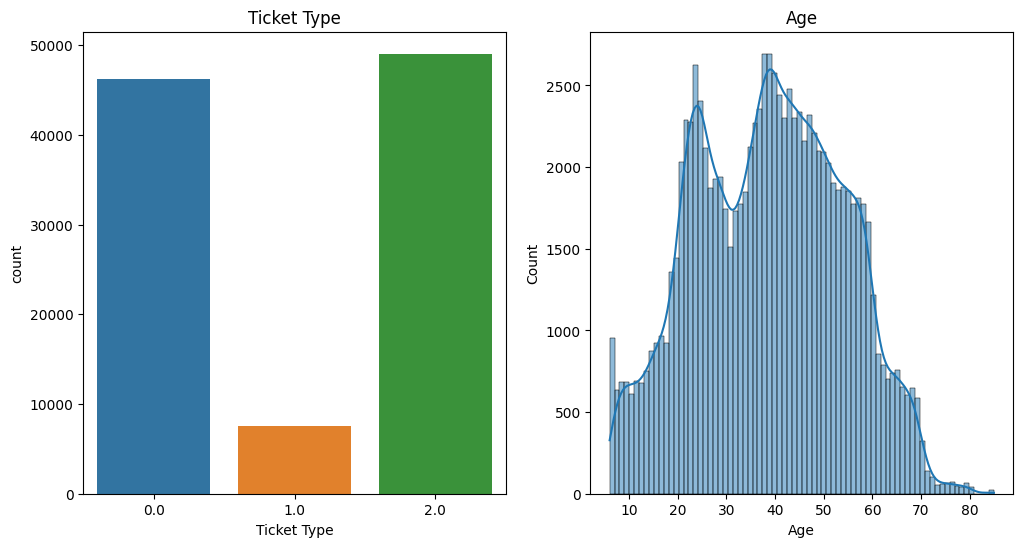

In [40]:
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot (Ticket Type)
sns.countplot(data=merged_data, x='Ticket Type', ax=axes[0])
axes[0].set_title('Ticket Type')

# Plot the second subplot (Age)
sns.histplot(data=merged_data, x='Age', ax=axes[1], kde=True)  # Set kde=True for density curve
axes[1].set_title('Age')

### Plot `Ticket Type` against `Age`
**Findings:**

`Age` is an important factor in determining `Ticket Type`
- Mean age for `Luxury` ticket is highest (~42), indicating older guests are more likely to purchase `Luxury`
- On the other hand, `Standard` ticket is lowest (~38), indicating more young guests purchased `Standard`
- Outliers are present for `Luxury` indicated by dots above the maximum
- Average `Age` of `Male` are higher than `Female`, indicating `Males` passengers are generally older than `Females` passengers

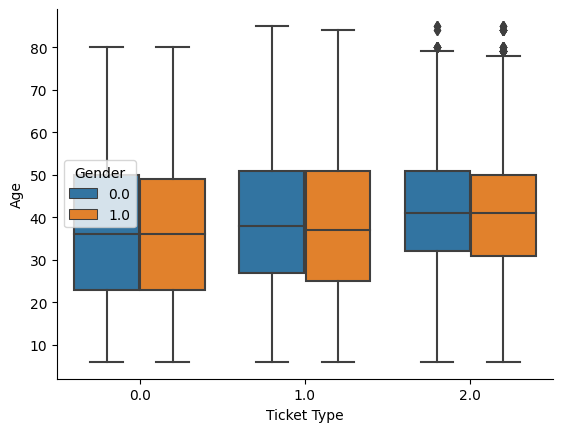

In [41]:
sns.boxplot(data=merged_data, x="Ticket Type", y="Age", hue='Gender')
sns.despine()

### Plot `Onboard Experience` against `Age`
This indicator is the average of:
1. Onboard Service
2. Onboard Dining Service
3. Onboard Entertainment
4. Cabin Service
5. Cabin Comfort
6. Cleanliness

**Findings:**
- Older people finds `Onboard Service` of lower priority (1.0 - 2.0)
- `Onboard Service` rating is evenly distributed across age groups
- `Onboard Entertainment` 
- `Cabin Comfort` is highly important for older passengers
- `Cabin Service` is quite evenly distributed, skewing slightly more to older passengers
- `Cleanliness` is less important for younger passengers, and more important for older passengers

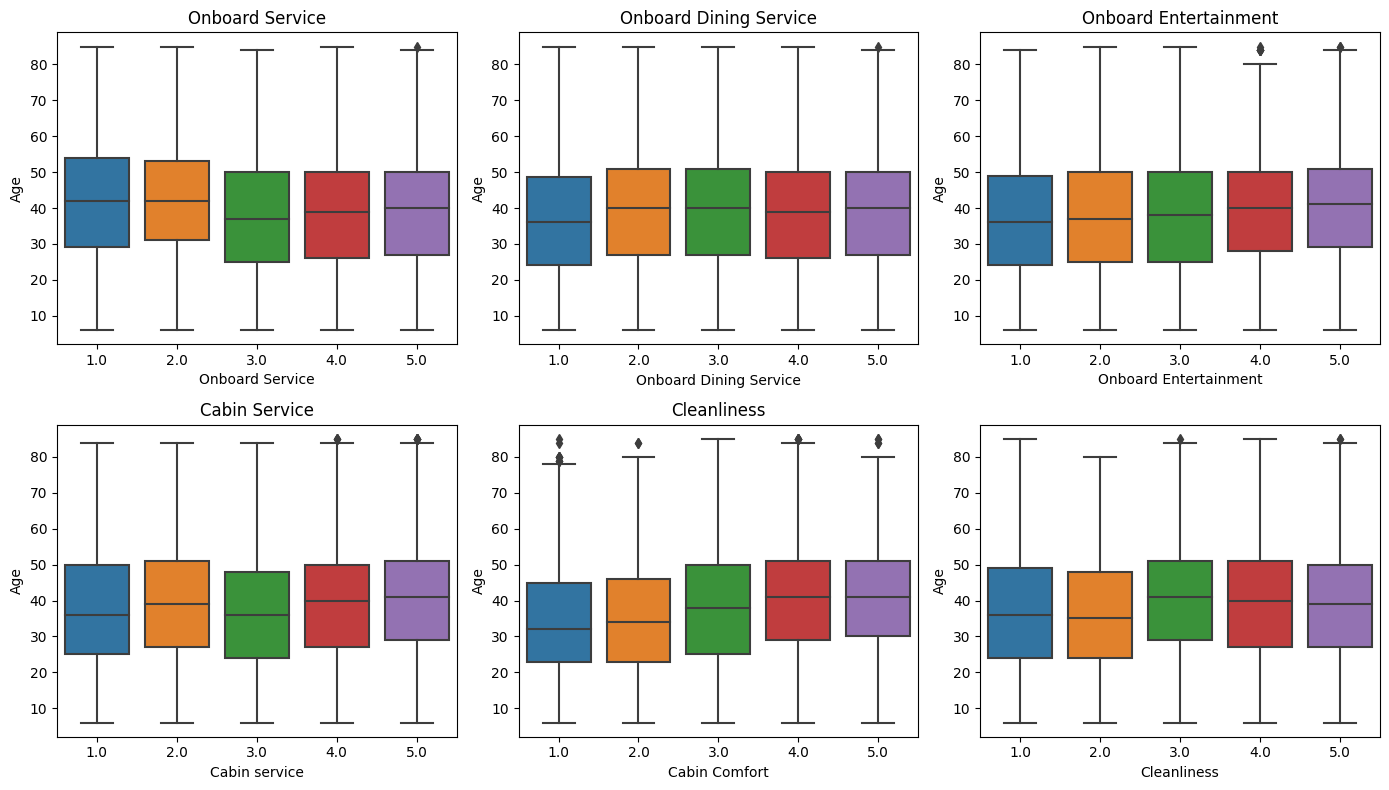

In [42]:
# Create a figure with 2 by 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Plot the first heatmap (cruise_pre_df)
sns.boxplot(data=merged_data, x="Onboard Service", y="Age", ax=axes[0,0])
axes[0,0].set_title('Onboard Service')

sns.boxplot(data=merged_data, x="Onboard Dining Service", y="Age", ax=axes[0,1])
axes[0,1].set_title('Onboard Dining Service')

sns.boxplot(data=merged_data, x="Onboard Entertainment", y="Age", ax=axes[0,2])
axes[0,2].set_title('Onboard Entertainment')

sns.boxplot(data=merged_data, x="Cabin service", y="Age", ax=axes[1,0])
axes[1,0].set_title('Cabin Service')

sns.boxplot(data=merged_data, x="Cabin Comfort", y="Age", ax=axes[1,1])
axes[1,1].set_title('Cabin Comfort')

sns.boxplot(data=merged_data, x="Cleanliness", y="Age", ax=axes[1,2])
axes[1,1].set_title('Cleanliness')

plt.tight_layout()

## Random Forest Features Importance Analysis
**Purpose:**
- To gain insights into which features are more important in predicting `Ticket Type`

**Findings:**
- `Age` is still the most influential in predicting `Ticket Type`
- `Onboard Experience` is significantly more important compared to `Check-in Experience`
- `Onboard Experience` importance factor is much higher than `Check-in Experience`

In [43]:
from sklearn.ensemble import RandomForestClassifier
ordinal_features = ['Check-in Experience', 'Onboard Experience', 'Age']

# Define X (features) and y (target)
X = merged_data[ordinal_features]
y = merged_data['Ticket Type']

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Fit the model
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': ordinal_features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
2,Age,0.575458
1,Onboard Experience,0.270774
0,Check-in Experience,0.153768


Further Analysis Using `Check-in Experience`, `Onboard Experience`, `Source of Traffic`, and `Gender`
**Findings:**
- `Onboard Experience` is the most influential feature in predicting ticket type
- `Source of Traffic` is also relevant, but to a much lesser extent compared to `Onboard Experience` and `Check-in Experience`
- `Gender` has almost no influence on the ticket type

In [44]:
ordinal_features = ['Source of Traffic','Check-in Experience','Onboard Experience', 'Gender']

# Define X (features) and y (target)
X = merged_data[ordinal_features]
y = merged_data['Ticket Type']

# Fit the model
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': ordinal_features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
2,Onboard Experience,0.514569
1,Check-in Experience,0.320910
0,Source of Traffic,0.150111
3,Gender,0.014410


## Correlation Analysis
**Purpose:**
- To find which variable has the strongest correlation to the `Ticket Type` that the guest purchase

**Findings:**
- `Cruise Distance` has the strongest correlation against `Ticket Type`, however this data is only available post-cruise, should not be used as part of training data.
- `Online Check-in` is the second strongest (0.3)
- `Onboard Experience`, a feature engineered in this project, has the third strongest (0.21)

In [64]:
import scipy.stats as stats
# 'Ticket Type' is encoded as [0, 1, 2]
# Define columns to be analysed against 'Ticket Type'
feature_columns = ['Gender', 'Source of Traffic', 'Onboard Wifi Service','Embarkation/Disembarkation time convenient', 'Ease of Online booking',
                    'Gate location', 'Onboard Dining Service', 'Online Check-in', 'Cabin Comfort', 'Onboard Entertainment', 'Cabin service',
                    'Baggage handling', 'Port Check-in Service', 'Onboard Service', 'Cleanliness', 'Cruise Distance', 'Age',
                    'Onboard Experience', 'Check-in Experience']

correlations = {}
# Loop through each feature column
for feature in feature_columns:
    # Calculate point biserial correlation
    r_pb, p_value = stats.pointbiserialr(merged_data[feature], merged_data['Ticket Type'])
    correlations[feature] = r_pb

# Print the correlations
print('Correlation between: ')
for feature, correlation in correlations.items():
    print(f'{feature} and Ticket Type: {correlation:.4f}')


Correlation between: 
Gender and Ticket Type: -0.0032
Source of Traffic and Ticket Type: -0.0919
Onboard Wifi Service and Ticket Type: 0.0529
Embarkation/Disembarkation time convenient and Ticket Type: -0.0925
Ease of Online booking and Ticket Type: 0.1041
Gate location and Ticket Type: 0.0028
Onboard Dining Service and Ticket Type: 0.0781
Online Check-in and Ticket Type: 0.3004
Cabin Comfort and Ticket Type: 0.2012
Onboard Entertainment and Ticket Type: 0.1831
Cabin service and Ticket Type: 0.1974
Baggage handling and Ticket Type: 0.1446
Port Check-in Service and Ticket Type: 0.1397
Onboard Service and Ticket Type: 0.1480
Cleanliness and Ticket Type: 0.1228
Cruise Distance and Ticket Type: 0.4106
Age and Ticket Type: 0.1379
Onboard Experience and Ticket Type: 0.2085
Check-in Experience and Ticket Type: 0.1600


In [60]:
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102806 entries, 2 to 141537
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      102806 non-null  float64
 1   Date of Birth                               102806 non-null  object 
 2   Source of Traffic                           102806 non-null  int64  
 3   Onboard Wifi Service                        102806 non-null  float64
 4   Embarkation/Disembarkation time convenient  102806 non-null  float64
 5   Ease of Online booking                      102806 non-null  float64
 6   Gate location                               102806 non-null  float64
 7   Logging                                     102806 non-null  object 
 8   Onboard Dining Service                      102806 non-null  float64
 9   Online Check-in                             102806 non-null  float64
 